In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch_geometric as pyg
import networkx as nx
from model.MinAggGNN import MinAggGNN

seed = 0
torch.manual_seed(seed)
rng = np.random.default_rng(seed)

device = torch.device('cuda')
K = 2
m = 2

model = MinAggGNN(1, 8, K, 1, edge_dim = 1)
model.to(device)

MinAggGNN(1, 1, num_layers=2)

In [2]:
train = torch.load('data/training_data.pt')
test = torch.load('data/test_data.pt')

train_loader = pyg.loader.DataLoader(train, batch_size = len(train))
num_reachable_nodes = sum([data.reachable.sum() for data in train])
test_loader = pyg.loader.DataLoader(test, batch_size = len(test))
num_reachable_test_nodes = sum([data.reachable.sum() for data in test])

In [3]:
from tqdm import tqdm
from model.CustomLosses import MultiplicativeLoss

criterion = torch.nn.MSELoss()
test_criterion = MultiplicativeLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)
epochs = 20000
eta = 0.001

def training():
    model.train()
    for data in train_loader:
        data.to(device)
        out = model(data.x, data.edge_index, edge_attr = data.edge_attr, batch = data.batch)
        mse_loss = criterion(out.flatten()[data.reachable], data.y[data.reachable])
        mse_loss /= num_reachable_nodes
        l1_regularization = torch.tensor(0., device=device)
        for param in model.parameters():
            l1_regularization += param.abs().sum()
        total_loss = mse_loss + eta * l1_regularization
        total_loss.backward()
        optimizer.step()
    return mse_loss, l1_regularization, total_loss

def testing():
    torch.no_grad()
    model.eval()
    total_loss = torch.tensor(0.)
    for data in test_loader:
        data.to(device)
        out = model(data.x, data.edge_index, edge_attr = data.edge_attr, batch = data.batch).flatten()
        total_loss += test_criterion(out[data.reachable], data.y[data.reachable]).cpu()
    total_loss /= num_reachable_test_nodes
    return total_loss.detach().cpu()

mse_losses = torch.zeros(epochs)
l1_regs = torch.zeros(epochs)
test_losses = torch.zeros(epochs)
model_checkpoints = []

pbar = tqdm(range(epochs))
for epoch in pbar:
    optimizer.zero_grad()
    mse_loss, l1_reg, total_loss = training()
    mse_losses[epoch] = mse_loss
    l1_regs[epoch] = l1_reg
    test_loss = testing()
    test_losses[epoch] = test_loss
    if epoch % 100 == 0:
        model_checkpoints.append({k: v.cpu() for k, v in model.state_dict().items()})
    pbar.set_description(f'Train MSE Loss: {float(mse_loss):.4f}, L1 Reg: {float(l1_reg):.4f}, Test Loss: {float(test_loss):.4f}')
model.eval()

  0%|          | 0/20000 [00:00<?, ?it/s]c:\Users\heje197\AppData\Local\miniconda3\envs\stargazer\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Train MSE Loss: 0.0002, L1 Reg: 15.4093, Test Loss: 0.0673: 100%|██████████| 20000/20000 [27:06<00:00, 12.29it/s] 


MinAggGNN(1, 1, num_layers=2)

In [ ]:
torch.save(model.state_dict(), 'model_progress/bellman_ford/model_final.pt')
torch.save(model_checkpoints, 'model_progress/bellman_ford/model_checkpoints.pt')
torch.save(mse_losses, 'model_progress/bellman_ford/mse_losses.pt')
torch.save(l1_regs, 'model_progress/bellman_ford/l1_regs.pt')
torch.save(test_losses, 'model_progress/bellman_ford/test_losses.pt')

In [2]:
import torch
model_checkpoints = torch.load('model_progress/bellman_ford/model_checkpoints.pt')
mse_losses = torch.load('model_progress/bellman_ford/mse_losses.pt')
l1_regs = torch.load('model_progress/bellman_ford/l1_regs.pt')
test_losses = torch.load('model_progress/bellman_ford/test_losses.pt')

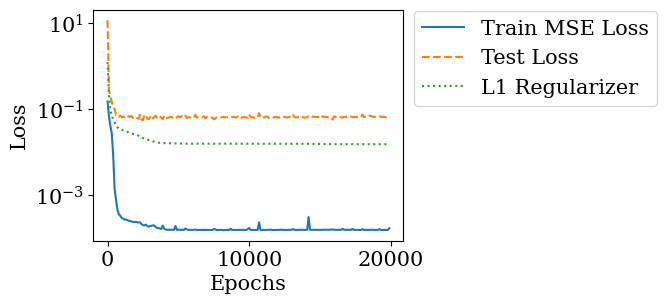

In [32]:
from matplotlib import pyplot as plt

eta = 0.001
epochs = 20000
plt.rcParams['font.size'] = 15
plt.rcParams['font.family'] = 'serif'
num_ticks = 2

fig, ax = plt.subplots(1,1, figsize = (4,3))
ax.plot(mse_losses[0:epochs:100].detach(), label='Train MSE Loss')
ax.plot(test_losses[0:epochs:100].detach(), label='Test Loss', ls='dashed')
ax.plot((eta * l1_regs)[0:epochs:100].detach(), label='L1 Regularizer', ls='dotted')

ax.set_xticks(range(0, len(model_checkpoints)+1, len(model_checkpoints) // num_ticks))
ax.set_xticklabels(range(0, epochs+1, epochs // num_ticks))
ax.set_xlabel('Epochs')

ax.set_yscale('log')
ax.set_ylabel('Loss')

fig.legend(bbox_to_anchor=(1.56, .91), loc='upper right')
plt.savefig('images/bellman_ford_loss.pdf', bbox_inches='tight')

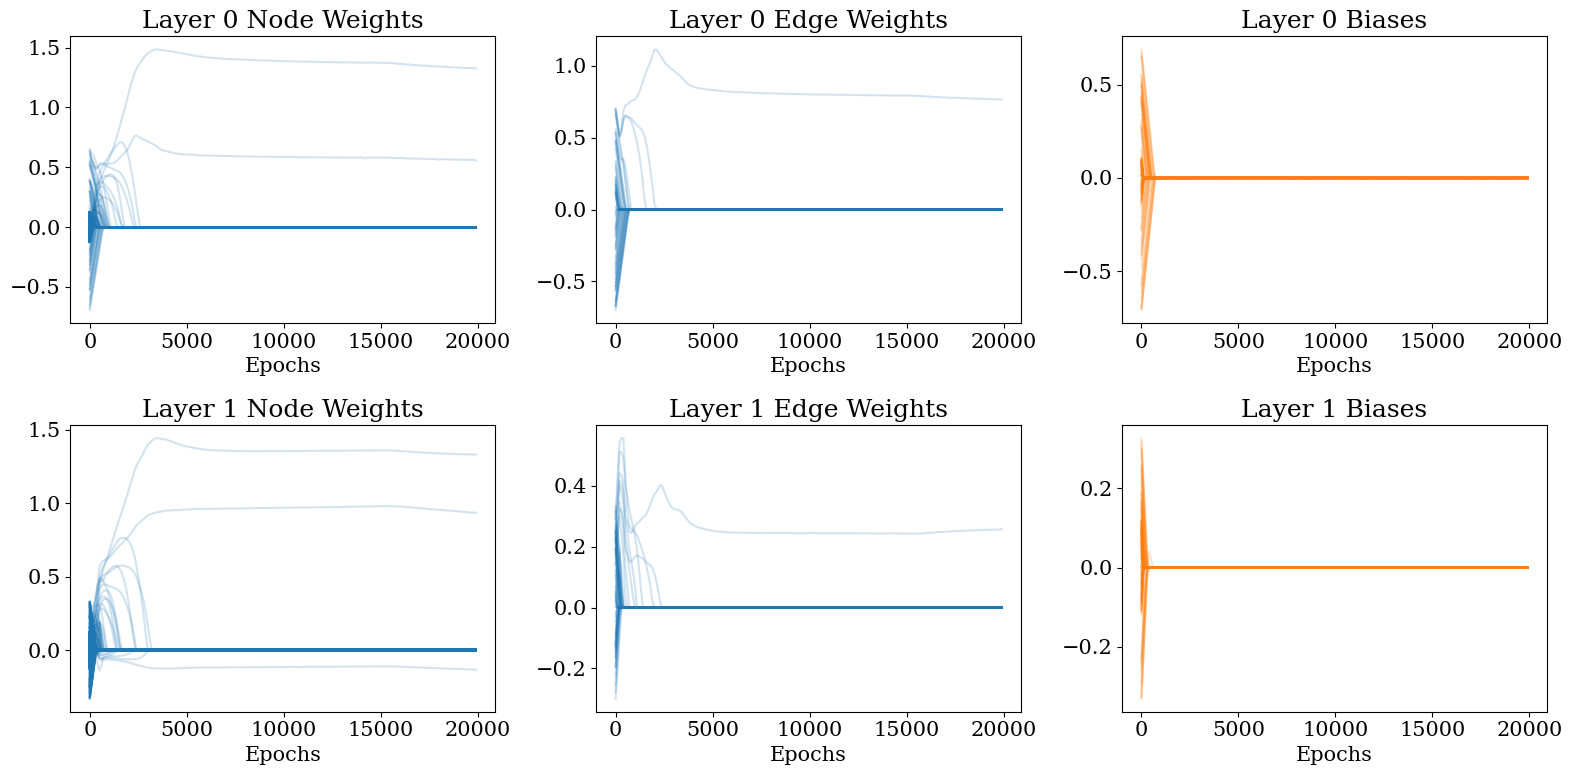

In [34]:
import matplotlib.pyplot as plt
node_weights_0 = torch.empty((len(model_checkpoints),
                         len(model.state_dict()['convs.0.agg_mlp.lins.0.weight'][:,:-1].flatten())
                         + len(model.state_dict()['convs.0.agg_mlp.lins.1.weight'][:,:-1].flatten())
                         ))
node_weights_1 = torch.empty((len(model_checkpoints),
                         len(model.state_dict()['convs.1.agg_mlp.lins.0.weight'][:,:-1].flatten())
                         + len(model.state_dict()['convs.1.agg_mlp.lins.1.weight'][:,:-1].flatten())
                         ))
edge_weights_0 = torch.empty((len(model_checkpoints),
                         len(model.state_dict()['convs.0.agg_mlp.lins.0.weight'][:,-1].flatten())
                         ))
edge_weights_1 = torch.empty((len(model_checkpoints),
                         len(model.state_dict()['convs.1.agg_mlp.lins.0.weight'][:,-1].flatten())
                         ))
biases_0 = torch.empty((len(model_checkpoints),
                         len(model.state_dict()['convs.0.agg_mlp.lins.0.bias'].flatten())
                         + len(model.state_dict()['convs.0.agg_mlp.lins.1.bias'].flatten())
                         ))
biases_1 = torch.empty((len(model_checkpoints),
                         len(model.state_dict()['convs.1.agg_mlp.lins.0.bias'].flatten())
                         + len(model.state_dict()['convs.1.agg_mlp.lins.1.bias'].flatten())
                         ))
for i, checkpoint in enumerate(model_checkpoints):
    node_weights_0[i] = torch.cat((checkpoint['convs.0.agg_mlp.lins.0.weight'][:,:-1].flatten(),
                              checkpoint['convs.0.agg_mlp.lins.1.weight'][:,:-1].flatten()))
    node_weights_1[i] = torch.cat((checkpoint['convs.1.agg_mlp.lins.0.weight'][:,:-1].flatten(),
                              checkpoint['convs.1.agg_mlp.lins.1.weight'][:,:-1].flatten()))
    edge_weights_0[i] = checkpoint['convs.0.agg_mlp.lins.0.weight'][:,-1].flatten()
    edge_weights_1[i] = checkpoint['convs.1.agg_mlp.lins.0.weight'][:,-1].flatten()
    biases_0[i] = torch.cat((checkpoint['convs.0.agg_mlp.lins.0.bias'].flatten(),
                              checkpoint['convs.0.agg_mlp.lins.1.bias'].flatten()))
    biases_1[i] = torch.cat((checkpoint['convs.1.agg_mlp.lins.0.bias'].flatten(),
                              checkpoint['convs.1.agg_mlp.lins.1.bias'].flatten()))
    
fig, ax = plt.subplots(2,3, figsize = (16,8))

n_ticks = 5
ax[0,0].set_title('Layer 0 Node Weights')
ax[0,0].plot(node_weights_0.detach(), c = 'tab:blue', alpha = 0.2)

ax[0,1].set_title('Layer 0 Edge Weights')
ax[0,1].plot(edge_weights_0.detach(), c = 'tab:blue', alpha = 0.2)

ax[0,2].set_title('Layer 0 Biases')
ax[0,2].plot(biases_0.detach(), c = 'tab:orange', alpha = 0.2)

ax[1,0].set_title('Layer 1 Node Weights')
ax[1,0].plot(node_weights_1.detach(), c = 'tab:blue', alpha = 0.2)

ax[1,1].set_title('Layer 1 Edge Weights')
ax[1,1].plot(edge_weights_1.detach(), c = 'tab:blue', alpha = 0.2)

ax[1,2].set_title('Layer 1 Biases')
ax[1,2].plot(biases_1.detach(), c = 'tab:orange', alpha = 0.2)

for axes in ax.flatten():
    axes.set_xticks(range(0, len(model_checkpoints)+1, len(model_checkpoints) // 4))
    axes.set_xticklabels(range(0, epochs+1, epochs // 4))
    axes.set_xlabel('Epochs')

# fig.suptitle('Parameter Summary')
fig.tight_layout()
plt.savefig('images/bellman_ford_params.pdf', bbox_inches='tight')